In [1]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os
from scipy.stats import chisquare
import itertools
import tqdm
import warnings
from scipy.optimize import OptimizeWarning
from sklearn.metrics import mean_squared_error

import matplotlib.colors as colors
#import statsmodels.api as sm
import matplotlib as mpl
import seaborn
# from stats import curve,curve_shift, sigmoid,sigmoid_0

In [2]:
warnings.simplefilter(action="ignore")

In [3]:
df = pd.read_excel("Detail.xlsx")
filelist = df["FileName"].dropna()

In [4]:
color_list=['#636EFA', '#EF553B','#FFA15A', '#00CC96', '#AB63FA','#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52','#636EFA', '#EF553B','#FFA15A', '#00CC96', '#AB63FA','#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']
color_cont=["#C0E5E8","#6FB5CC","#3E6DB2","#3A3C7D","#17172F"]
marker_=["o","^","s","*","h"]
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['xtick.direction'] = 'in' # x axis in
plt.rcParams['ytick.direction'] = 'in' # y axis in 
plt.rcParams.update({
    "font.family": "Arial",
    "font.sans-serif":"Arial",
})

In [5]:
df_al=pd.read_csv("fit_cr_David.csv")
dict_al=df_al.to_dict(orient='records')
dict_all=sorted(dict_al, key=lambda d: d['λint/aff'], reverse=True)

In [6]:
def curve(x,a,b):
     return a*(x**(-b))+1

def curve_shift(x,c):
        # 0.39*((x-c)**(-1.19))+1 #aggregate
        # 0.49*((x-c)**(-0.98))+1 #average
        return 0.64*((x-c)**(-1.48))+1 #David

        
def sigmoid(x, k2, k3, k1,k4):
            return k2-(k3 / (1 + np.exp(-k1*(x-k4))))


def sigmoid_0(x, k2, k1,k4):
        return k2-(k2 / (1 + np.exp(-k1*(x-k4))))

def sigmoid_plus_curve(x,a,b,k2, k3, k1,k4):
        return a*((x)**(-b))+k2-(k3 / (1 + np.exp(k1*(x-k4))))

def linear(x,a):
        return a*x 

def poly(x, k2, k3, k4,k5,k6):
        return np.polyval([k2, k3, k4,k5,k6],x)

In [7]:
def MakeScale(dict_all):
    scale=np.array([x["λint/aff"] for x in dict_all])
    lscale=np.log(scale)
    scale_=(lscale-np.log(0.5))/(lscale.max()-np.log(0.5))
    cmap=plt.cm.get_cmap("rainbow")
    norm=colors.LogNorm(vmin=0.5, vmax=30)
    return scale_,cmap,norm

In [8]:
def CBar(scale_,cmap,norm):
    
    fig, ax = plt.subplots(figsize=(0.5, 6))
    cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='vertical', ticks=[0.5,1,2,5,10,20,30])
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_yticklabels(['0.5', '1', '2',"5","10","20","30"])
    plt.savefig('plot_onlycbar.png',dpi=800,bbox_inches="tight")


In [9]:
def mod_eachsample(force,sample):
    df_filtered=df_al[(df_al["Force"].isin(force))&(df_al["Int"].isin(sample))]
    dict_all=df_filtered.to_dict(orient='records')

    fig = plt.figure(figsize=(8,6))
    ax=fig.add_subplot(1,1,1)
    lin=np.linspace(0,30,100)
    lin_small=np.linspace(0,1,10)

    for i,x in enumerate(dict_all):
        df_=pd.DataFrame()
        df_=pd.read_csv(x["path"]).dropna()
        A_cap=df_["A_cap"].mean()
        A_ff=df_["ContactRadius"].mean()
        df_large=df_[(A_cap/A_ff<=df_["normalized_distance"] ) ]
        df_small=df_[(A_cap/A_ff>=df_["normalized_distance"] ) ]
        ax.fill_between(x=df_["normalized_distance"],y1=df_["normalized_modulus"]-df_["normalized_modulus_std"],y2=df_["normalized_modulus"]+df_["normalized_modulus_std"],color=color_list[i],alpha=0.3)
        ax.scatter(df_small["normalized_distance"],df_small["normalized_modulus"],facecolor="#FFFFFF",edgecolor=color_list[i],s=60,alpha=1,marker=marker_[i])
        ax.scatter(df_large["normalized_distance"],df_large["normalized_modulus"],color=color_list[i],s=60,alpha=1,marker=marker_[i])

    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    ax.set_ylim([0,10])
    ax.set_xlim([0,20])
  
    ax.plot(lin,curve_shift(lin,0),color="k",label="FEA")
    ax.plot(lin_small,curve_shift(lin_small,0),linestyle="dashed",color="k")


    plt.savefig(f'{force}_{sample}_mod_20.png', dpi=800,bbox_inches="tight")

In [10]:
def mod_0(force):
    df_filtered=df_al[(df_al["Force"].isin(force))&(df_al["Int"].isin([0]))]
    dict_all=df_filtered.to_dict(orient='records')

    fig = plt.figure(figsize=(8,6))
    ax=fig.add_subplot(1,1,1)
    lin=np.linspace(1,30,1000)
    lin_small=np.linspace(0,1,10)
    label=["R=15nm","R=30nm","R=300nm"]

    for i,x in enumerate(dict_all):
        df_=pd.DataFrame()
        df_=pd.read_csv(x["path"]).dropna()
        A_cap=df_["A_cap"].mean()
        A_ff=df_["ContactRadius"].mean()
        df_large=df_[(A_cap/A_ff<=df_["normalized_distance"] ) ]
        df_small=df_[(A_cap/A_ff>=df_["normalized_distance"] ) ]
        ax.fill_between(x=df_["normalized_distance"],y1=df_["normalized_modulus"]-df_["normalized_modulus_std"],y2=df_["normalized_modulus"]+df_["normalized_modulus_std"],color=color_list[i],alpha=0.3)
        ax.scatter(df_small["normalized_distance"],df_small["normalized_modulus"],facecolor="#FFFFFF",edgecolor=color_list[i],s=60,alpha=1,marker=marker_[i])
        ax.scatter(df_large["normalized_distance"],df_large["normalized_modulus"],color=color_list[i],s=60,alpha=1,marker=marker_[i],label=label[i])

    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    ax.set_ylim([0,10])
    ax.set_xlim([0,10])
  
    ax.plot(lin,curve_shift(lin,0),color="k",label="FEA")
    ax.plot(lin_small,curve_shift(lin_small,0),color="k",linestyle="dashed")
    

    # ax.plot(lin,curve(lin,0.64,1.68),color="k",label="FEA", linestyle="dashed")
    # ax.plot(lin_small,curve(lin_small,0.64,1.68),linestyle="dashed",color="k")
    # ax.legend(loc="lower center",ncol=4,fontsize=16, bbox_to_anchor=(.5, 1.05),)
    plt.savefig(f'{force}_nointerphase_10.png', dpi=800,bbox_inches="tight")

In [11]:
def diff_eachsample(force,sample):
    df_filtered=df_al[(df_al["Force"].isin(force))&(df_al["Int"].isin(sample))]
    dict_all=df_filtered.to_dict(orient='records')

    fig = plt.figure(figsize=(8,6))
    ax=fig.add_subplot(1,1,1)

    for i,x in enumerate(dict_all):
        df_=pd.DataFrame()
        df_=pd.read_csv(x["path"]).dropna()
        df_["diff"]=df_["normalized_modulus"]-curve_shift(df_["normalized_distance"],0)
        A_cap=df_["A_cap"].mean()
        A_ff=df_["ContactRadius"].mean()
        df_large=df_[(A_cap/A_ff<=df_["normalized_distance"] ) ]
        df_small=df_[(A_cap/A_ff>=df_["normalized_distance"] ) ]
        ax.fill_between(x=df_["normalized_distance"],y1=df_["diff"]-df_["normalized_modulus_std"],y2=df_["diff"]+df_["normalized_modulus_std"],color=color_list[i],alpha=0.3)
        ax.scatter(df_small["normalized_distance"],df_small["diff"],facecolor="#FFFFFF",edgecolor=color_list[i],s=60,alpha=1,marker=marker_[i])
        ax.scatter(df_large["normalized_distance"],df_large["diff"],color=color_list[i],s=60,alpha=1,marker=marker_[i])

    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    ax.set_ylim([-0.6,3])
    ax.set_xlim([0,30])

    plt.savefig(f'{force}_{sample}_diff.png', dpi=800,bbox_inches="tight")

In [12]:
def shift_eachsample(force,sample):
    df_filtered=df_al[(df_al["Force"].isin(force))&(df_al["Int"].isin(sample))]
    dict_all=df_filtered.to_dict(orient='records')

    fig = plt.figure(figsize=(8,6))
    ax=fig.add_subplot(1,1,1)

    for i,x in enumerate(dict_all):
        df_=pd.DataFrame()
        df_=pd.read_csv(x["path"]).dropna()
        df_["diff"]=df_["normalized_modulus"]-curve_shift(df_["normalized_distance"],0)
        Aff=df_["ContactRadius"].mean()
        interphase_thickness=x["λint/aff"]*Aff
        A_cap=df_["A_cap"].mean()

        df_large=df_[(A_cap/Aff<=df_["normalized_distance"] ) ]
        df_small=df_[(A_cap/Aff>=df_["normalized_distance"] ) ]
        ax.fill_between(x=(df_["distance"]-interphase_thickness)/Aff,y1=df_["diff"]-df_["normalized_modulus_std"],y2=df_["diff"]+df_["normalized_modulus_std"],color=color_list[i],alpha=0.3)
        ax.scatter((df_small["distance"]-interphase_thickness)/Aff,df_small["diff"],facecolor="#FFFFFF",edgecolor=color_list[i],s=60,alpha=1,marker=marker_[i])
        ax.scatter((df_large["distance"]-interphase_thickness)/Aff,df_large["diff"],color=color_list[i],s=60,alpha=1,marker=marker_[i])

    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    ax.set_ylim([-0.6,3])
    ax.set_xlim([-10,10])

    plt.savefig(f'{force}_{sample}_shift.png', dpi=800,bbox_inches="tight")

In [13]:
def mod_all(force,sample):
    df_filtered=df_al[(df_al["Force"].isin(force))&(df_al["Int"].isin(sample))]
    dict_all=df_filtered.sort_values(by=['λint/aff'], ascending=False).to_dict(orient='records')   
    scale_,cmap,norm=MakeScale(dict_all)

    fig = plt.figure(figsize=(8,6))
    ax=fig.add_subplot(1,1,1)
    lin=np.linspace(0,30,100)
    lin_small=np.linspace(0,1,10)



    for i,x in enumerate(dict_all):
        df_=pd.DataFrame()
        df_=pd.read_csv(x["path"]).dropna()
        A_cap=df_["A_cap"].mean()
        A_ff=df_["ContactRadius"].mean()
        df_large=df_[(A_cap/A_ff<=df_["normalized_distance"] ) ]
        df_small=df_[(A_cap/A_ff>=df_["normalized_distance"] ) ]


        ############################ plot #########################
        ax.fill_between(x=df_["normalized_distance"],y1=df_["normalized_modulus"]-df_["normalized_modulus_std"],y2=df_["normalized_modulus"]+df_["normalized_modulus_std"],color=cmap(scale_[i]),alpha=0.3)
        ax.scatter(df_small["normalized_distance"],df_small["normalized_modulus"],facecolor="#FFFFFF",edgecolor=cmap(scale_[i]),s=60,alpha=1)
        ax.scatter(df_large["normalized_distance"],df_large["normalized_modulus"],color=cmap(scale_[i]),s=60,alpha=1)


    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    ax.set_ylim([0,10])
    ax.set_xlim([0,30])
 

    ax.plot(lin,curve_shift(lin,0),color="k",label="FEA")
    ax.plot(lin_small,curve_shift(lin_small,0),linestyle="dashed",color="k")
    plt.savefig(f'all_mod_{force}.png', dpi=800,bbox_inches="tight")
    CBar(scale_,cmap,norm)

In [14]:
def diff_all(force,sample):

    df_filtered=df_al[(df_al["Force"].isin(force))&(df_al["Int"].isin(sample))]
    dict_all=df_filtered.sort_values(by=['λint/aff'], ascending=False).to_dict(orient='records')


    scale_,cmap,norm=MakeScale(dict_all)

    fig = plt.figure(figsize=(8,6))
    ax=fig.add_subplot(1,1,1)

    for i,x in enumerate(dict_all):
        df_=pd.DataFrame()
        df_=pd.read_csv(x["path"]).dropna()
        df_["diff"]=df_["normalized_modulus"]-curve_shift(df_["normalized_distance"],0)
        A_cap=df_["A_cap"].mean()
        A_ff=df_["ContactRadius"].mean()
        df_large=df_[(A_cap/A_ff<=df_["normalized_distance"] ) ]
        df_small=df_[(A_cap/A_ff>=df_["normalized_distance"] ) ]


        ############################ plot #########################
        ax.fill_between(x=df_["normalized_distance"],y1=df_["diff"]-df_["normalized_modulus_std"],y2=df_["diff"]+df_["normalized_modulus_std"],color=cmap(scale_[i]),alpha=0.3)
        ax.scatter(df_small["normalized_distance"],df_small["diff"],facecolor="#FFFFFF",edgecolor=cmap(scale_[i]),s=60,alpha=1)
        ax.scatter(df_large["normalized_distance"],df_large["diff"],color=cmap(scale_[i]),s=60,alpha=1)

    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    ax.set_ylim([-0.6,3])
    ax.set_xlim([0,30])

    plt.savefig(f'all_diff_{force}.png', dpi=800,bbox_inches="tight")

In [15]:
def diff_all_cover(force,sample):

    df_filtered=df_al[(df_al["Force"].isin(force))&(df_al["Int"].isin(sample))]
    dict_all=df_filtered.sort_values(by=['λint/aff'], ascending=False).to_dict(orient='records')


    scale_,cmap,norm=MakeScale(dict_all)
    lin=np.linspace(0,30,100)
    lin_small=np.linspace(0,1,10)


    for i,x in enumerate(dict_all):
        fig = plt.figure(figsize=(8,6))
        ax=fig.add_subplot(1,1,1)
        df_=pd.DataFrame()
        df_=pd.read_csv(x["path"]).dropna()
        df_["diff"]=df_["normalized_modulus"]-curve_shift(df_["normalized_distance"],0)
        A_cap=df_["A_cap"].mean()
        A_ff=df_["ContactRadius"].mean()
        df_large=df_[(A_cap/A_ff<=df_["normalized_distance"] ) ]
        df_small=df_[(A_cap/A_ff>=df_["normalized_distance"] ) ]


        ############################ plot #########################
        ax.fill_between(x=df_["normalized_distance"],y1=df_["normalized_modulus"]-df_["normalized_modulus_std"],y2=df_["normalized_modulus"]+df_["normalized_modulus_std"],color=cmap(scale_[i]),alpha=0.3)
        ax.scatter(df_small["normalized_distance"],df_small["normalized_modulus"],facecolor="#FFFFFF",edgecolor=cmap(scale_[i]),s=60,alpha=1)
        ax.scatter(df_large["normalized_distance"],df_large["normalized_modulus"],color=cmap(scale_[i]),s=60,alpha=1)



        ax.set_ylim([0,10])
        ax.set_xlim([0,30])
        plt.xticks([])
        plt.yticks([])
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['bottom'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)

        if i==11:
            ax.plot(lin,curve_shift(lin,0),color="k",label="FEA")
            ax.plot(lin_small,curve_shift(lin_small,0),linestyle="dashed",color="k")

        


        plt.savefig(f'all_diff_{force}_{i}.png', dpi=800,bbox_inches="tight",transparent=True)

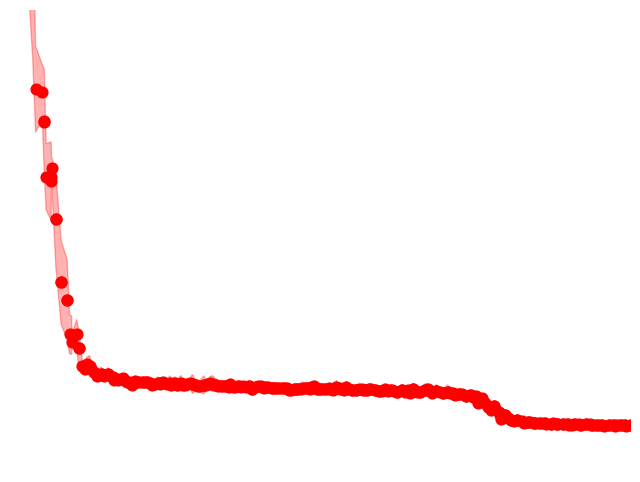

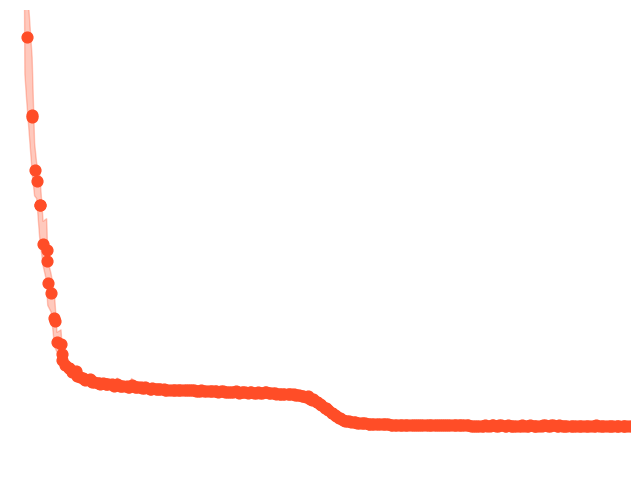

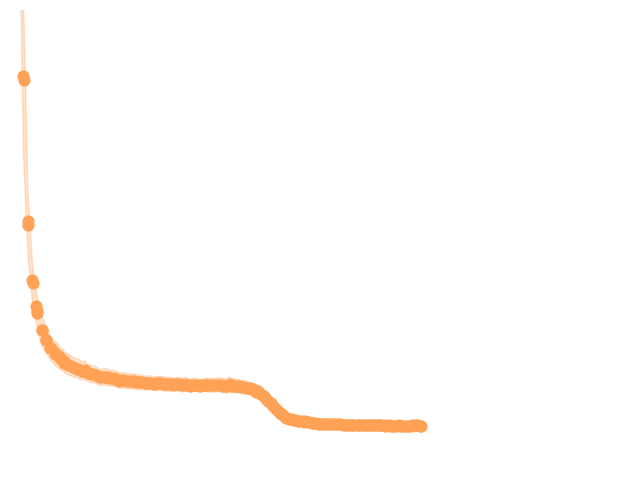

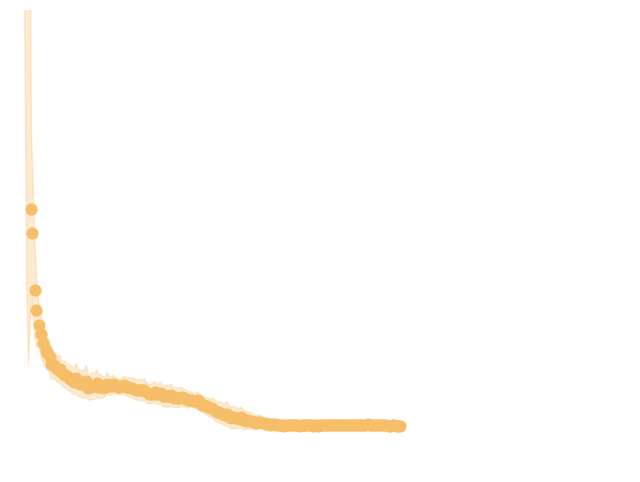

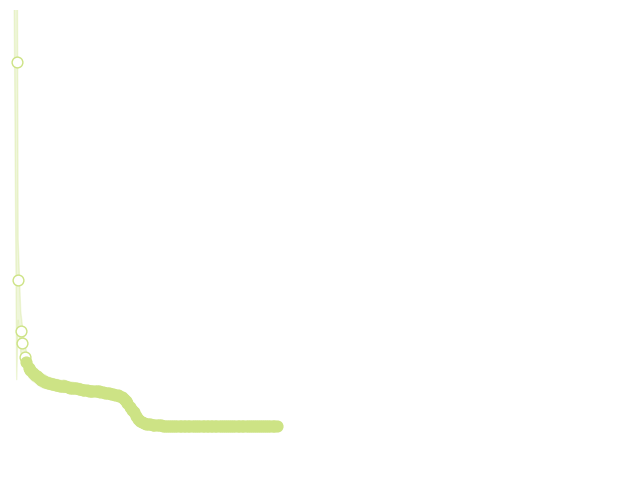

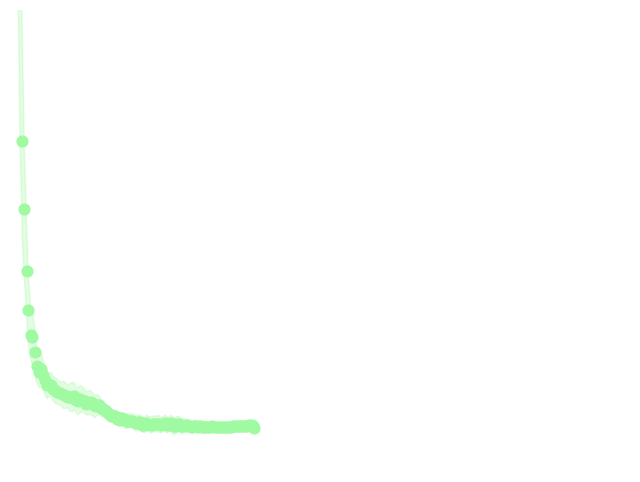

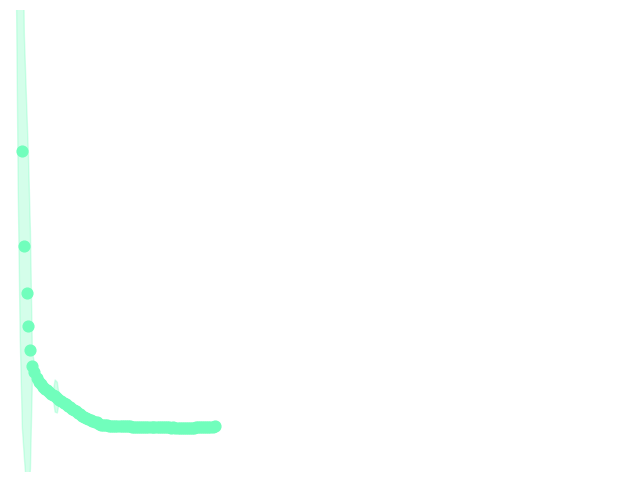

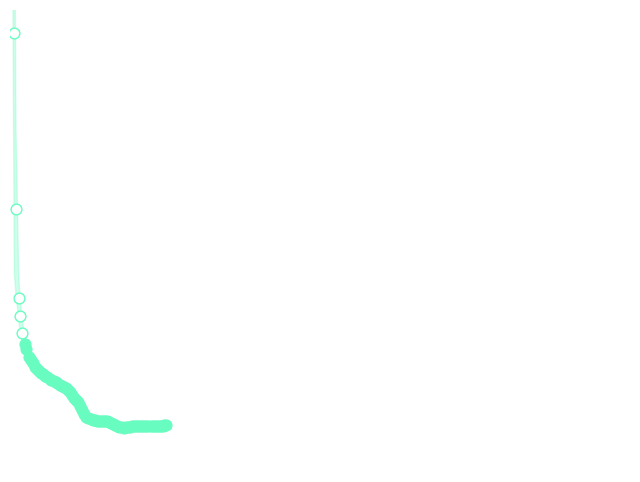

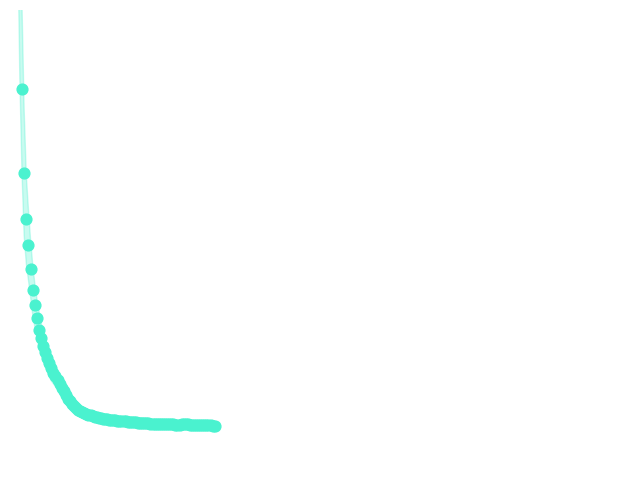

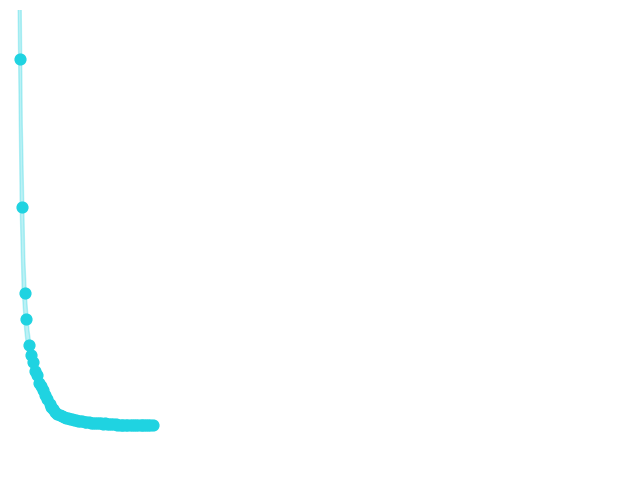

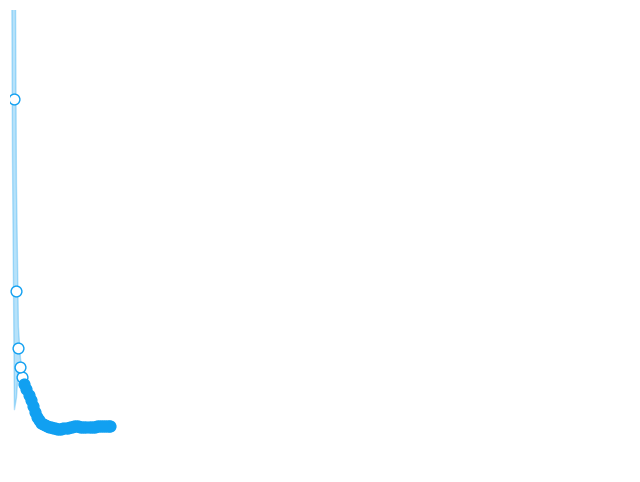

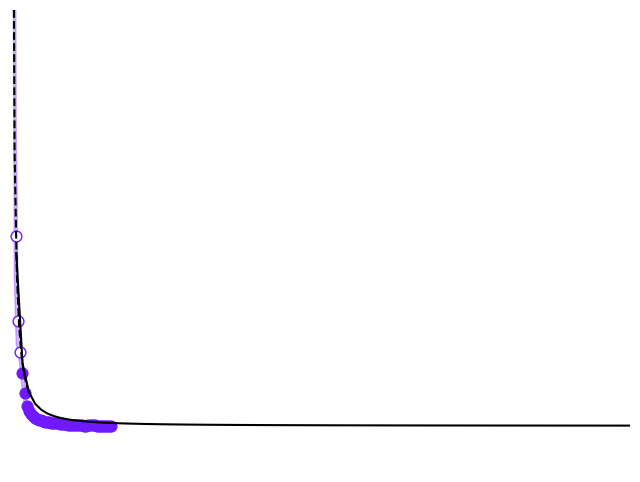

In [16]:
sample=[50,150,500,1000]
diff_all_cover([75],sample)

In [15]:
def diff_all_sigmoid(force,sample):

    df_filtered=df_al[(df_al["Force"].isin(force))&(df_al["Int"].isin(sample))]
    dict_all=df_filtered.sort_values(by=['λint/aff'], ascending=False).to_dict(orient='records')

    scale_,cmap,norm=MakeScale(dict_all)

    fig = plt.figure(figsize=(8,6))
    ax=fig.add_subplot(1,1,1)
    lin=np.linspace(0,30,100)
    

    for i,x in enumerate(dict_all):
        df_=pd.DataFrame()
        df_=pd.read_csv(x["path"]).dropna()
        df_["diff"]=df_["normalized_modulus"]-curve_shift(df_["normalized_distance"],0)
        A_cap=df_["A_cap"].mean()
        A_ff=df_["ContactRadius"].mean()
        df_large=df_[(A_cap/A_ff<=df_["normalized_distance"] ) ]
        df_small=df_[(A_cap/A_ff>=df_["normalized_distance"] ) ]
        sig_=x["sigmoid_fit"].replace("["," ").replace("]"," ").split(" ")
        sig_params=[float(s) for s in sig_ if s.strip()]


        ############################ plot #########################
        ax.fill_between(x=df_["normalized_distance"],y1=df_["diff"]-df_["normalized_modulus_std"],y2=df_["diff"]+df_["normalized_modulus_std"],color=cmap(scale_[i]),alpha=0.3)
        ax.scatter(df_small["normalized_distance"],df_small["diff"],facecolor="#FFFFFF",edgecolor=cmap(scale_[i]),s=60,alpha=1)
        ax.scatter(df_large["normalized_distance"],df_large["diff"],color=cmap(scale_[i]),s=60,alpha=1)
        ax.plot(lin,sigmoid_0(lin,*sig_params),linestyle="-",color="k")

    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    ax.set_ylim([-0.6,3])
    ax.set_xlim([0,30])

    plt.savefig(f'all_diff_sigmoid_{force}.png', dpi=800,bbox_inches="tight")

In [21]:
def Fig_8(force,sample):
    df_filtered=df_al[(df_al["Force"].isin(force))&(df_al["Int"].isin(sample))]
    dict_all=df_filtered.to_dict(orient='records')
    scale_,cmap,norm=MakeScale(dict_all)


    int_pred_all=np.array([x["λpred/aff"]*x["Aff"] for x in dict_all])
    Aff_=np.array([x["Aff"] for x in dict_all])
    int_all=np.array([x["λint/aff"]*x["Aff"] for x in dict_all])
    fit_score=np.array([x["fit_score"] for x in dict_all])
    Emin=np.array([x["E_lower"] for x in dict_all])
    Emax=np.array([x["E_upper"] for x in dict_all])

 

    min_=np.array([x["lower"]*x["Aff"] for x in dict_all])
    max_=np.array([x["upper"]*x["Aff"] for x in dict_all])
    # e_std=np.array([x["E_err"] for x in dict_all])
    asymmetric_error = np.abs(np.array(list(zip(min_-int_pred_all, int_pred_all-max_)))).T
    asymmetric_error_e = np.abs(np.array(list(zip(fit_score-Emin, Emax-fit_score)))).T

    fig=plt.figure(figsize=(4.5,4.5))
    ax=fig.add_subplot(111)
    ax.scatter(int_all,int_pred_all,c=scale_,cmap="rainbow",s=60)
    for i,x in enumerate(asymmetric_error.T):
        ax.errorbar(int_all[i],int_pred_all[i],yerr=x.reshape(2,1),c=cmap(scale_[i]))
    ax.plot(np.linspace(50,1500),np.linspace(50,1500),color="k",alpha=0.5)

    ax.set_ylim([50,1500])
    ax.set_xlim([50,1500])
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    ax.set_xscale("log")
    ax.set_yscale("log")
    plt.savefig(f'lambda_pred_{force}.png', dpi=800,bbox_inches="tight")

    fig=plt.figure(figsize=(6,4))
    ax=fig.add_subplot(111)
    for i,x in enumerate(asymmetric_error_e.T):
        ax.errorbar(int_all[i]/Aff_[i],fit_score[i],yerr=x.reshape(2,1),c=cmap(scale_[i]))

    ax.fill_between(x=[0,3],y1=[-1,-1],y2=[3,3],color="k",alpha=0.2)
    ax.scatter(int_all/Aff_,fit_score,s=60,c=cmap(scale_))
 

    ax.set_xlim([0,30])
    ax.set_ylim([-1,2])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.savefig(f'lower_resolution_{force}.png', dpi=800,bbox_inches="tight")




    fig=plt.figure(figsize=(6,4))
    ax=fig.add_subplot(111)

    ax.fill_between(x=[0,3],y1=[0.1,0.1],y2=[10000,10000],color="k",alpha=0.2)
    ax.scatter(int_all/Aff_,np.abs(max_-min_),s=60,c=cmap(scale_))


    ax.set_xlim([0,30])
    ax.set_ylim([0.1,10000])
    ax.set_yscale("log")
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.savefig(f'std_{force}.png', dpi=800,bbox_inches="tight")

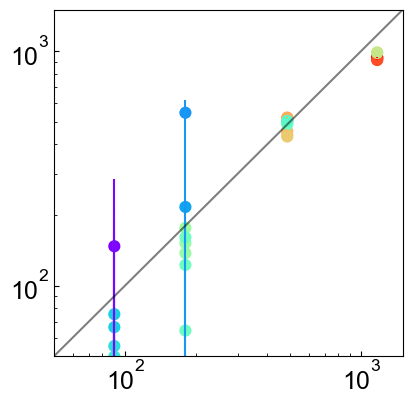

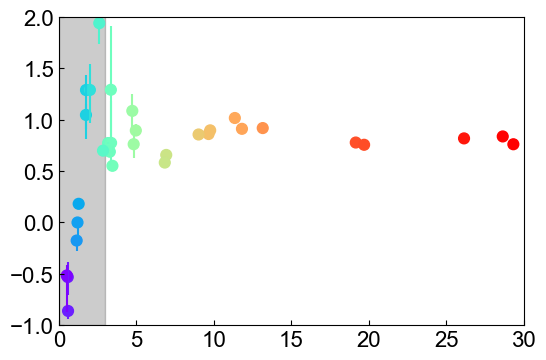

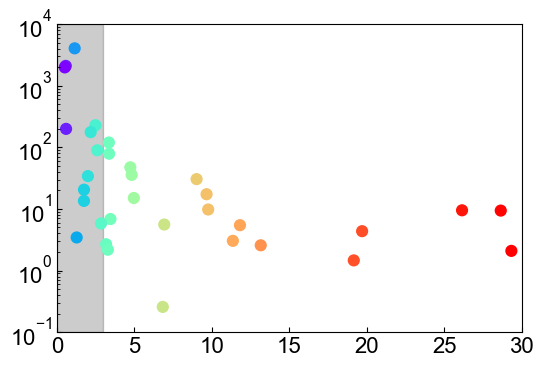

In [23]:

# Fig_8([75],sample)

# mod_all([75],sample)
# diff_all([75],sample)
# diff_all_sigmoid([75],sample)


# for i in sample:
#     mod_eachsample([75],[i])
#     diff_eachsample([75],[i])
#     shift_eachsample([75],[i])
# mod_eachsample([75],[1000])
#mod_0([75])
Fig_8([50,75,100],sample)

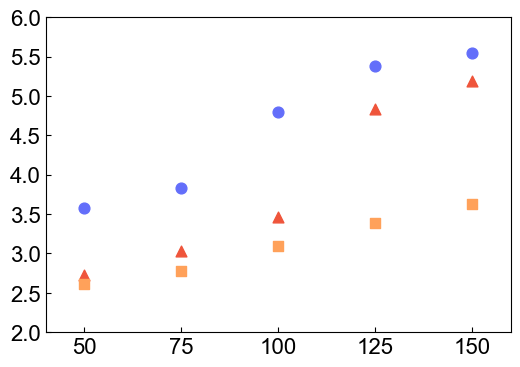

In [42]:
probe=["HQ300","HQ30030","NCH"]
force=[50,75,100,125,150]
hm_a=np.zeros((len(probe),len(force)))
hm_d=np.zeros((len(probe),len(force)))
comb=[]
fig=plt.figure(figsize=(6,9))
ax=fig.add_subplot(211)
for p_,p in enumerate(probe):
    for f_,f in enumerate(force):
        a_hat= df[(df["Probe"]==p) & (df["ForceSetpoint"]==f)]["a_hat"].mean()
        d_hat=df[(df["Probe"]==p) & (df["ForceSetpoint"]==f)]["d_hat"].mean()
        hm_a[p_,f_]=a_hat
        hm_d[p_,f_]=d_hat
    ax.scatter(force,hm_d[p_,:],label=p,color=color_list[p_],marker=marker_[p_],s=60)
# ax.legend(loc="upper left")
ax.set_xlim(40,160)
ax.set_ylim(2,6)
plt.xticks([50,75,100,125,150],fontsize=16)
plt.yticks(fontsize=16)
# ax.legend(loc="upper left",fontsize=14)
# ax.set_xlabel(r" Force Setpoint [nN]",fontsize=20)
# ax.set_ylabel("Non dimensional depth ",fontsize=20)
plt.savefig(f'd_hat.png', dpi=800,bbox_inches="tight")

# hm__a=pd.DataFrame(hm_a,index=probe,columns=force)
# hm__d=pd.DataFrame(hm_d,index=probe,columns=force)

[170]
[286]
[552]
[991]


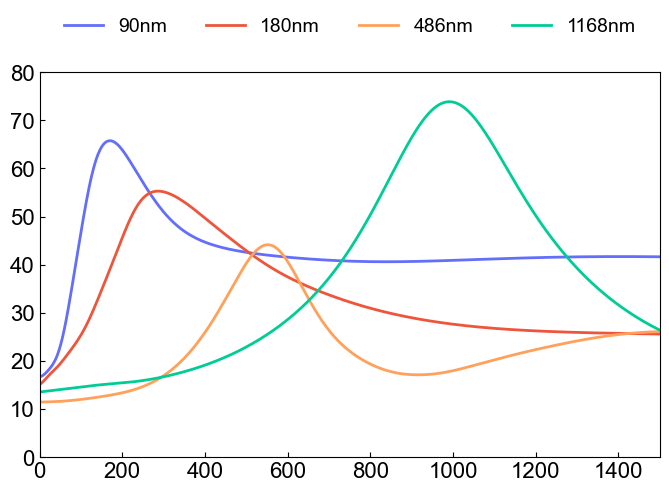

In [15]:

chi_all=pd.read_csv("reduced_RMS.csv",index_col=[0]).to_numpy()
label=["90nm","180nm","486nm", "1168nm"]


x_axis=np.arange(0,1500,1)
fig=plt.figure(figsize=(8,5))
ax=fig.add_subplot(111)
for i in range(0,4):
    ax.plot(x_axis,np.array(chi_all[:,i]),label=f"{label[i]}",c=color_list[i],linewidth=2)
    print(f"{x_axis[[np.array(chi_all[:,i]).argmax()]]}")
# ax.set_xlabel("predicted interphase thickness [nm]",fontsize=20)
# ax.set_ylabel("Reduced RMS [-]",fontsize=20)
# ax.legend(loc="upper right",fontsize=14)
ax.set_xlim([0,1500])
ax.set_ylim([0,80])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='lower center', bbox_to_anchor=(.5, 1.05), ncol=4,fontsize=14,frameon = False)
fig.savefig(fname=f"reduced_RMS.png",dpi=800,bbox_inches="tight",pad_inches=0)